## Aim

Compute an ABC occurrence rate estimate, and compare results with ```occurrence_mcmc```.

In [1]:
import sys
sys.path.append('..')
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
from scipy import optimize, stats, linalg
from dev.abc import ABCSampler
from dev import price_rogers_2014_binned, dataprocessing, completeness
from tqdm.notebook import tqdm
from scipy.stats import gamma
from functools import partial

%load_ext autoreload
%autoreload 2

My ABC setup requires

- a prior occurrence estimate.
- a candidate generator for the model parameters $\theta$, i.e. a ```stats.continuous_rv/stats.discrete_rv``` object whose .rvs() method returns candidate parameters.
- a sampler for $f(x \mid \theta)$
- distance and statistic functions
- data to fit

In [41]:
kois = dataprocessing.get_kois()
stellar = dataprocessing.get_stellar()
kois = kois[kois["kepid"].isin(stellar["kepid"])]
kois = kois[np.isfinite(kois["koi_prad"])]
stellar = stellar[np.isfinite(stellar.mass)]

[190585   5222    508    153     59     21      2      2]


Text(0, 0.5, 'Counts')

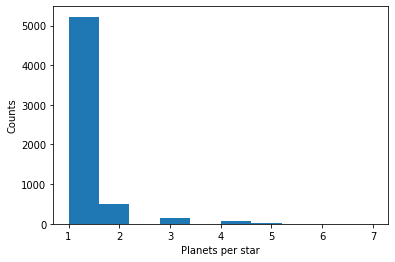

In [42]:
zerocounts = len(stellar[~stellar["kepid"].isin(kois["kepid"])])
solarsyssizes = np.array(pd.crosstab(index=kois['kepid'], columns="count")).flatten()
bincounts = np.bincount(solarsyssizes)
bincounts[0] = zerocounts
print(bincounts)
plt.hist(solarsyssizes)
plt.xlabel("Planets per star")
plt.ylabel("Counts")

Now the dataset has sufficient complexity to fit a Poisson process.

In [43]:
assert np.all(np.isfinite(kois["koi_prad"]))
assert np.all(np.isfinite(kois["koi_period"]))
koi_radii = kois["koi_prad"]
koi_periods = kois["koi_period"]

In [44]:
lam = np.mean(solarsyssizes)
# lam = sum([i * k for i, k in enumerate(bincounts)]) / sum(bincounts)
planet_numbers = np.minimum(stats.poisson(lam).rvs(size=(len(stellar),)), 10) 
print([sum(planet_numbers == i) for i in range(max(planet_numbers))])

[59752, 71499, 42145, 16706, 4926, 1153, 236, 47, 2]


In [45]:
lam

1.183844477962125

(array([5.9752e+04, 7.1499e+04, 4.2145e+04, 1.6706e+04, 4.9260e+03,
        1.1530e+03, 2.3600e+02, 4.7000e+01, 2.0000e+00, 2.0000e+00]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

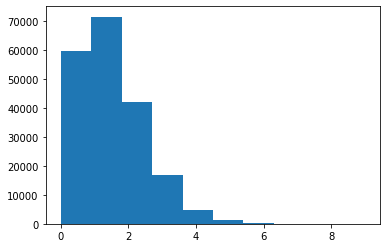

In [46]:
plt.hist(planet_numbers)

In [47]:
period = np.array([0.5, 1.25, 2.5, 5, 10, 20, 40, 80, 160, 320])
rp = np.array([0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.5, 3, 4, 6, 8, 12, 16])
log_p, log_r = np.log(period), np.log(rp)
log_p = np.append(log_p, np.log(640))
log_r = np.append(log_r, np.log(20))
period_rng = (min(period), max(period))
rp_rng = (min(rp), max(rp))

f = np.histogram2d(koi_periods, koi_radii, bins=[period, rp])[0]
# f = np.ones(shape=(len(period), len(rp)))

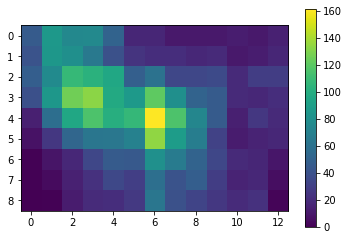

In [48]:
plt.imshow(np.histogram2d(koi_periods, koi_radii, bins=[period, rp])[0]) # I guess that's sorta like an H-R diagram?
plt.colorbar()

In [49]:
f = lam * f / np.sum(f)

In [50]:
bucket = np.random.choice(f.size, p=f.flatten() / np.sum(f))
i, j = bucket // f.shape[1], bucket % f.shape[1] 
synth_p = np.exp(np.random.uniform(log_p[i], log_p[i+1]))
synth_r = np.exp(np.random.uniform(log_r[j], log_r[j+1]))
ecc = stats.rayleigh(scale=0.03).rvs()
cosincl = np.random.uniform(-1, 1)
print("Generated planet with period {0} days, radius {1} Earth radii, eccentricity {2}, cos of orbital inclination {3}.".format(np.round(synth_p, 3), np.round(synth_r, 3), np.round(ecc, 3), np.round(cosincl, 3)))

Generated planet with period 12.401 days, radius 0.769 Earth radii, eccentricity 0.032, cos of orbital inclination -0.892.


In [51]:
cdpp_cols = [k for k in stellar.keys() if k.startswith("rrmscdpp")]
cdpp_vals = np.array([k[-4:].replace("p", ".") for k in cdpp_cols], dtype=float)
pgam = gamma(4.65, loc=0., scale=0.98)
mesthres_cols = [k for k in stellar.keys() if k.startswith("mesthres")]
mesthres_vals = np.array([k[-4:].replace("p", ".") for k in mesthres_cols],
                         dtype=float)

In [61]:
def pcomp_vectors(stars, periods, rp, eccs, cosincls):
    '''
    Self-contained, returns pcomp over matched arrays of planets around stars.
    '''
    c = 1.0874
    s = 1.0187
    Go4pi = 2945.4625385377644/(4*np.pi*np.pi)
    re = 0.009171
    
    mstars = stars['mass'].values
    rstars = stars['radius'].values
    cdpp = np.array(stars[cdpp_cols], dtype=float)
    dataspan = stars['dataspan'].values
    dutycycle = stars['dutycycle'].values
    mesthres_cols_stars = np.array(stars[mesthres_cols], dtype=float)
    
    aor = (Go4pi*periods*periods*mstars) ** (1./3) / rstars
    tau = 6 * periods * np.sqrt(1 - eccs**2) / aor

    sigma = np.array([np.interp(tau[i], cdpp_vals, cdpp[i]) for i in range(len(tau))])
    # Compute the radius ratio and estimate the S/N.

    k = rp * re / rstars
    delta = 0.84 * k*k * (c + s*k)
    snr = delta * 1e6 / sigma

    # Scale by the estimated number of transits.
    ntrn = dataspan * dutycycle / periods
    mess = snr * np.sqrt(ntrn)
    mest = np.array([np.interp(tau[i], mesthres_vals, mesthres_cols_stars[i]) for i in range(len(tau))])
    x = mess - 4.1 - (mest - 7.1)
    pdets = pgam.cdf(x)
    pdets = np.nan_to_num(pdets)
    
    M = dataspan / periods
    f = dutycycle
    omf = 1.0 - f
    pw = 1 - omf**M - M*f*omf**(M-1) - 0.5*M*(M-1)*f*f*omf**(M-2)
    msk = (pw >= 0.0) & (M >= 2.0)
    pwins = pw * msk
    pwins = np.nan_to_num(pwins)
    
    pgeom = aor * cosincls * (1 - eccs * eccs) <= 1 # for now, assume sin omega = 0
    # pgeom = 1. / (aor * (1 - eccs*eccs)) * (aor > 1.0)
    
    pgeom = np.nan_to_num(pgeom)
    
    try:
        assert np.all(pdets >= 0) and np.all(pdets <= 1), "pdets are out of range"
        assert np.all(pwins >= 0) and np.all(pwins <= 1), "pwins are out of range"
        assert np.all(pgeom >= 0) and np.all(pgeom <= 1), "pgeom are out of range"
    except AssertionError as e:
        for p in [pdets, pwins, pgeom]:
            print(min(p), np.nanmean(p), max(p))
        raise
    return pdets * pwins * pgeom

Text(0.5, 1.0, 'pcomps')

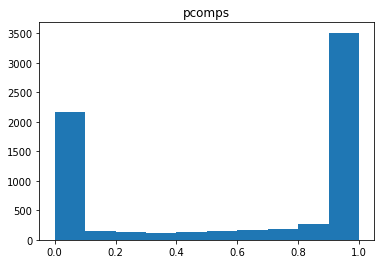

In [65]:
combined = pd.merge(kois, stellar, on='kepid')
pcomp = partial(completeness.get_completeness, pgam=pgam, mesthres_cols=mesthres_cols, mesthres_vals=mesthres_vals)
cosincls = np.cos(np.pi * combined['koi_incl'] / 180)
pcomps = pcomp_vectors(combined, combined['koi_period'], combined['koi_prad'], combined['koi_eccen'], cosincls)
plt.hist(pcomps[~np.isnan(pcomps)])
plt.title("pcomps")

In [66]:
num_stars = len(stellar)
stellar_sample = stellar.sample(n=num_stars)

In [71]:
t0_range = (min(kois.koi_time0), max(kois.koi_time0))

def add_uncertainties(price_uncertainty_params):
    '''
    Adds uncertainties to parameters based on Price and Rogers (2014).
    
    Arguments
    ---------
    price_uncertainty_parameters : list of scalars / numpy.ndarrays.
    The parameters in the signature from each of the Price/Rogers variance functions.
    (delta, T, tau, f0, texp, Ttot, gamma, sigma).
    delta - transit depth
    T - full-width at half-max transit time
    tau - duration of ingress and egress
    f0 - starting flux, which we set to 1.
    texp - time of exposure, about 30 minutes for Kepler.
    Ttot -  same as P in this case, I think
    gamma - sampling rate
    sigma - model uncertainty
    
    Returns
    -------
    perturbed_parameters : list of scalars / numpy.ndarrays.
    The same list, but with white noise added.
    '''
    var_d = abs(np.vectorize(price_rogers_2014_binned.prVarDelta)(*price_uncertainty_params)) * 0 # abs is stopgap
    noise = np.random.normal(0, np.sqrt(var_d), size=(len(price_uncertainty_params[0]),))
    noise = np.nan_to_num(noise)
    price_uncertainty_params[0] += noise
    return price_uncertainty_params

def generate_planet_catalog(f, stars):
    '''
    Takes in the occurrence rate matrix f and generates `num_planets' planets, 
    represented as a matrix of state (row) vectors.
    
    Each row has: period in days; radius in Earth radii; eccentricity; cosine of inclination; impact parameter;
    time of first transit in BJD; fractional transit depth; transit duration in days; is_detected (bool).
    
    Arguments
    ---------
    f : np.ndarray
    f = f(r, p); occurrence rate prior that we sample p and r from.
    
    stars : pd.dataframe
    A list of tuples with stellar parameters (may edit this to deal with dataframe later.)
    '''
    re = 0.009171
    planet_params = ['kepid', 'period', 'prad', 'ecc', 'cosincl', 'b', 't0', 'd', 'D']
    lam = np.sum(f)
    nums_planets = np.minimum(stats.poisson(lam).rvs((len(stars),)), 10)
    num_planets = sum(nums_planets)
    star_kepids = np.repeat(stars.kepid.values, nums_planets)
    star_radius = np.repeat(stars.radius.values, nums_planets)
    star_mass = np.repeat(stars.mass.values, nums_planets)
    flat_f = f.flatten()
    buckets = np.random.choice(f.size, p = flat_f / lam, size=(num_planets,))
    p_left_inds = buckets // f.shape[1]
    p_right_inds = p_left_inds + 1
    r_left_inds = buckets % f.shape[1]
    r_right_inds = r_left_inds + 1
    periods = np.exp(np.random.uniform(log_p[p_left_inds], log_p[p_right_inds]))
    pl_rads = np.exp(np.random.uniform(log_r[r_left_inds], log_r[r_right_inds]))
    eccens  = stats.rayleigh(scale=0.03).rvs(size=(num_planets,))
    cosincl = np.random.uniform(0, 1, size=(num_planets,))
    impacts = np.random.uniform(0, 1, size=(num_planets,))
    t0 = np.random.uniform(*t0_range, size=(num_planets,))
    ror = pl_rads * re / star_radius
    depths = ror ** 2
    aor = completeness.get_a(periods, star_mass) / star_radius
    arcsin_args = np.sqrt((1 + ror) ** 2 - impacts ** 2) / aor
    D = (periods / np.pi) * np.arcsin(arcsin_args)
    tau0 = periods * impacts / (2 * np.pi * cosincl * np.sqrt(1 - eccens ** 2)) * 1 / (aor ** 2)
    T = 2 * tau0 * np.sqrt(1 - impacts ** 2)
    tau = 2 * tau0 * ror / np.sqrt(1 - impacts ** 2)
    f0 = 1
    texp = 1765.5 / 60 / 60 / 24 # s to days
    gamma = 1 / texp # inverse s to inverse days
    sigma = 1 # 'model uncertainty'
    
    price_uncertainty_params = [depths, T, tau, f0, texp, periods, gamma, sigma]
    price_uncertainty_params = add_uncertainties(price_uncertainty_params)
    
    depths = price_uncertainty_params[0]

    pl_rads = np.sqrt(depths) * star_radius / re
    periods = price_uncertainty_params[5]
    # [kepid, period, radius, ecc, cosincl, impact param b, t0, transit depth d, transit duration D, is_detected]
    planets_matrix = np.vstack((star_kepids, periods, pl_rads, eccens, cosincl, impacts, t0, depths, D)).T
    catalog = pd.DataFrame(planets_matrix, columns=planet_params)
    combined_synth = pd.merge(catalog, stellar, on='kepid')
    probs = pcomp_vectors(combined_synth, combined_synth['period'].values, 
                          combined_synth['prad'].values, combined_synth['ecc'].values, 
                          combined_synth['cosincl'].values)
    probs = np.nan_to_num(np.array(probs))
    if np.allclose(probs, 0):
        print("all probabilities of detection are 0")
    detected = np.random.binomial(1, probs)
    combined_synth['is_detected'] = detected
    return combined_synth.astype({'kepid': np.int64, 'is_detected': bool})

In [72]:
catalog_synth = generate_planet_catalog(f, stellar_sample)
if len(stellar_sample) == len(stellar):
    catalog_synth.to_csv('../data/catalog_synth.csv')

/Users/adityasengupta/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in arcsin
/Users/adityasengupta/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in greater_equal


In [73]:
sum(catalog_synth.is_detected)

12656

In [74]:
detected_planets = catalog_synth[catalog_synth.is_detected]

(array([3253., 2318., 2205., 1942., 1422.,  837.,  367.,  180.,   96.,
          36.]),
 array([-0.69297536, -0.05384039,  0.58529458,  1.22442955,  1.86356452,
         2.50269949,  3.14183446,  3.78096943,  4.4201044 ,  5.05923937,
         5.69837434]),
 <a list of 10 Patch objects>)

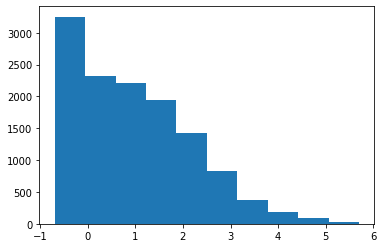

In [77]:
plt.hist(np.log(detected_planets.period))

(array([ 173., 1124., 2746., 3131., 1925., 1081.,  637.,  562.,  499.,
         778.]),
 array([-6.91685525e-01, -3.45305919e-01,  1.07368661e-03,  3.47453292e-01,
         6.93832898e-01,  1.04021250e+00,  1.38659211e+00,  1.73297172e+00,
         2.07935132e+00,  2.42573093e+00,  2.77211053e+00]),
 <a list of 10 Patch objects>)

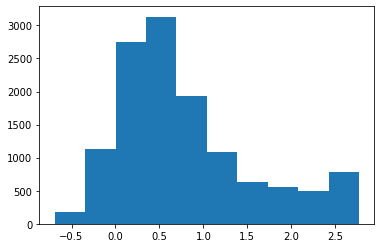

In [78]:
plt.hist(np.log(detected_planets.prad))

In [79]:
N = np.zeros_like(f)
detected = catalog_synth[catalog_synth.is_detected]
period_bins = np.digitize(np.log(detected.period), log_p)
radius_bins = np.digitize(np.log(detected.prad), log_r)
for i, j in zip(period_bins, radius_bins):
    if i < N.shape[0] and j < N.shape[1]: # exclude some on the edges
        N[i][j] += 1
        
N /= len(stellar_sample)

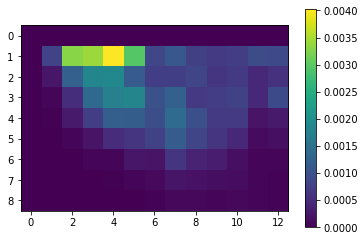

In [80]:
plt.imshow(N)
plt.colorbar()

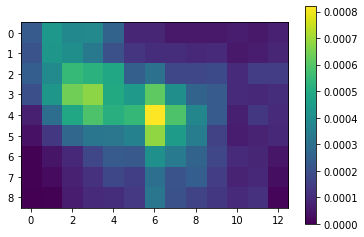

In [81]:
sample_N = np.histogram2d(koi_periods, koi_radii, bins=[period, rp])[0] / len(stellar)
plt.imshow(sample_N)
plt.colorbar()

In [82]:
diff = N - sample_N
statistic = np.sum(diff ** 2)
statistic

6.352146743400001e-05

In [96]:
stellar_sample_size = 100
stellar_sample = stellar.sample(n=stellar_sample_size)

class SyntheticCatalog:
    def __init__(self, f, stars):
        self.f = f
        self.stars = stars
        self.catalog = generate_planet_catalog(f, stars)

class OccurrencePrior(stats.rv_continuous):
    def pdf(self, f):
        return np.prod(np.exp(-f))
    
    def rvs(self):
        return stats.expon.rvs(size=(len(period), len(rp)))
    
def occurrence_candidate_getter(f):
    def candidate(size=1):
        catalogs = [SyntheticCatalog(f, stellar_sample) for _ in range(size)]
        return np.array([np.vstack((c.catalog.period, c.catalog.prad, c.catalog.is_detected)).T for c in catalogs])
    return candidate
    
def occurrence_distance(s1, s2):
    return np.sum((s1 - s2) ** 2)

def occurrence_statistic(catalogs):
    for catalog in catalogs:
        N = np.zeros_like(f)
        found_inds = np.where(catalog.catalog[:,2] == 1)[0]
        detected = catalog[found_inds]
        Nstars = len(catalog.stars)
        period_bins = np.digitize(np.log(detected[:,0]), log_p)
        radius_bins = np.digitize(np.log(detected[:,1]), log_r)
        for i, j in zip(period_bins, radius_bins):
            if i < N.shape[0] and j < N.shape[1]: # exclude some on the edges
                N[i][j] += 1
    return N / Nstars
    
OccurrenceABCSampler = ABCSampler(OccurrencePrior(), occurrence_candidate_getter, occurrence_distance, occurrence_statistic)


In [ ]:
kois_abc = [np.vstack((kois.koi_period, kois.koi_prad, kois.koi_disposition == "CONFIRMED")).T]
kois_abc

In [97]:
candidate = occurrence_candidate_getter(f)()

/Users/adityasengupta/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in arcsin


In [98]:
abc_f = OccurrenceABCSampler.sample(kois_abc, threshold=1e-1, verbose=True)

/Users/adityasengupta/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in arcsin


AttributeError: 'numpy.ndarray' object has no attribute 'catalog'

In [ ]:
plt.imshow(abc_f)

In [ ]:
plt.imshow(f)

In [ ]:
# Do not run till this is rewritten to be vectorized
stellar_sample_size = len(stellar)
stellar_sample = [row for row in stellar.sample(n=stellar_sample_size).itertuples()]
OccurrenceABCSampler = ABCSampler(OccurrencePrior(), occurrence_candidate_getter, occurrence_distance, occurrence_statistic)
abc_f_full = OccurrenceABCSampler.sample(kois_abc, threshold=1e-5)

impact parameter > 1: either a FP, or on the edge of the star. The transiting object has to be big, and often that's actually a star.

In [ ]:
# Do not run till this is rewritten to be vectorized
abc_pmc_f = OccurrenceABCSampler.sample_pmc(kois_abc, [1e-2, 1e-3, 1e-4, 1e-5, 1e-6], 1)

In [ ]:
i = 10
p = combined['koi_period'][i]
r = combined['koi_prad'][i]
rstar = combined['radius'][i]
ror = r / rstar * 0.009158
d = ror ** 2
b = combined['koi_impact'][i]
cosincl = np.cos(combined['koi_incl'][i] * np.pi / 180)
ecc = stats.rayleigh(scale=0.03).rvs() * 0
aor = completeness.get_a(p, combined['mass'][i]) / rstar
tau0 = p * b / (2 * np.pi * cosincl * np.sqrt(1 - ecc ** 2)) * 1 / (aor ** 2)
T = 2 * tau0 * np.sqrt(1 - b ** 2)
D = (p / np.pi) * np.arcsin(np.sqrt((1 + p / rstar) ** 2 - b ** 2) / aor)
tau0 = p * b / (2 * np.pi * cosincl * np.sqrt(1 - ecc ** 2)) * 1 / (aor ** 2)
T = 2 * tau0 * np.sqrt(1 - b ** 2)
tau = 2 * tau0 * r / np.sqrt(1 - b ** 2)
f0 = 1
texp = 1765.5 / 60 / 60 / 24 # s to days
gamma = 1 / texp # inverse s to inverse days
sigma = 1 # 'model uncertainty'
price_uncertainty_params = [d, T, tau, f0, texp, p, gamma, sigma]
print(price_rogers_2014_binned.prVarDelta(*price_uncertainty_params))

In [ ]:
print(p, r, rstar, b, cosincl, ecc)

In [ ]:
bad_kepids = np.load('../data/bad_kepids.npy')
len(set(bad_kepids) & set(kois.kepid))